# 1.0 Get and view data

In [ ]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import (avg, col, concat_ws, count, date_format,
                                   expr, from_json, from_unixtime,
                                   from_utc_timestamp, length, regexp_replace,
                                   sha2, split, sum, trim, when)
from pyspark.sql.types import StructType, StructField, StringType
from uszipcode import SearchEngine

In [2]:
data_path = os.path.join('..', 'data', 'cc_sample_transaction.json')
spark = SparkSession.builder.appName('CC Data Analysis').getOrCreate()
raw_cc_data = spark.read.json(data_path)
raw_cc_data.limit(5).show()  # Looking at the first 5 rows

+----------+------+-------------+-----------+----------------+--------+----------------+----------------------+------------------+-----------+-------------+--------------------+--------------------+---------------------+--------------------+
|Unnamed: 0|   amt|     category|     cc_bic|          cc_num|is_fraud|  merch_eff_time|merch_last_update_time|         merch_lat| merch_long|merch_zipcode|            merchant|     personal_detail|trans_date_trans_time|           trans_num|
+----------+------+-------------+-----------+----------------+--------+----------------+----------------------+------------------+-----------+-------------+--------------------+--------------------+---------------------+--------------------+
|         0|  4.97|     misc_net|CITIUS33CHI|2703186189652095|       0|1325376018798532|         1325376018666|         36.011293| -82.048315|        28705|fraud_Rippin, Kub...|{"person_name":"J...|  2019-01-01 00:00:18|0b242abb623afc578...|
|         1|107.23|  grocery_pos

In [3]:
raw_cc_data.select('personal_detail').limit(5).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|personal_detail                                                                                                                                                                                                                                                                      |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{"person_name":"Jennifer,Banks,eeeee","gender":"F","address":"{\"street\":\"561 Perry Cove\",\"city\":\"Moravian Falls\",\"state\":\"NC\",\"zip\":\"28654\"}","

# 2.0 Data Transformation

## 2.1 Parse `personal_detail` column

In [ ]:
transformed_cc_data = raw_cc_data.select('*')
address_schema = StructType([
    StructField('street', StringType(), True),
    StructField('city', StringType(), True),
    StructField('state', StringType(), True),
    StructField('zip', StringType(), True)
])

personal_details_schema = StructType([
    StructField('person_name', StringType(), True),
    StructField('gender', StringType(), True),
    StructField('address', StringType(), True),
    StructField('lat', StringType(), True),
    StructField('long', StringType(), True),
    StructField('city_pop', StringType(), True),
    StructField('job', StringType(), True),
    StructField('dob', StringType(), True)
])

transformed_cc_data = transformed_cc_data.withColumn(
    'personal_detail_parsed',
    from_json(col('personal_detail'), personal_details_schema))

transformed_cc_data = transformed_cc_data.withColumn(
    'address_parsed',
    from_json(col('personal_detail_parsed.address'), address_schema))

transformed_cc_data = transformed_cc_data.select(
    col('Unnamed: 0').alias('id'),
    col('amt').alias('amount'),
    col('is_fraud'),
    col('category'),
    col('merchant'),
    col('trans_date_trans_time'),
    col('cc_num'),
    col('personal_detail_parsed.person_name').alias('cc_owner'),
    col('personal_detail_parsed.gender').alias('gender'),
    col('personal_detail_parsed.job').alias('job'),
    col('personal_detail_parsed.dob').alias('date_of_birth'),
    col('address_parsed.street').alias('address_street'),
    col('address_parsed.city').alias('address_city'),
    col('address_parsed.state').alias('address_state'),
    col('address_parsed.zip').alias('address_zipcode'),
    col('personal_detail_parsed.lat').alias('cc_owner_lat'),
    col('personal_detail_parsed.long').alias('cc_owner_long'),
    col('personal_detail_parsed.city_pop').alias('city_population'),
    col('merch_eff_time'),
    col('merch_last_update_time'),
    col('merch_lat'),
    col('merch_long'),
    col('merch_zipcode'),
    col('cc_bic'),
    col('trans_num')
)

transformed_cc_data.limit(10).show()

+---+------+--------+-------------+--------------------+---------------------+--------------------+------+--------------------+-------------+--------------------+--------------+-------------+---------------+------------+------------------+---------------+----------------+----------------------+------------------+------------------+-------------+-----------+----------------+--------------------+
| id|amount|is_fraud|     category|            merchant|trans_date_trans_time|            cc_owner|gender|                 job|date_of_birth|      address_street|  address_city|address_state|address_zipcode|cc_owner_lat|     cc_owner_long|city_population|  merch_eff_time|merch_last_update_time|         merch_lat|        merch_long|merch_zipcode|     cc_bic|          cc_num|           trans_num|
+---+------+--------+-------------+--------------------+---------------------+--------------------+------+--------------------+-------------+--------------------+--------------+-------------+-------------

## 2.2 Casting columns

In [19]:
col_dtypes = {
    'id': 'integer',
    'amount': 'float',
    'trans_date_trans_time': 'timestamp',
    'cc_owner_lat': 'float',
    'cc_owner_long': 'float',
    'city_population': 'integer',
    'merch_eff_time': 'long',
    'merch_last_update_time': 'long',
    'merch_lat': 'float',
    'merch_long': 'float'
}

# Change multiple column types
for column in col_dtypes.keys():
    transformed_cc_data = transformed_cc_data.withColumn(
        column, col(column).cast(col_dtypes[column]))

## 2.3 Timestamp Conversion

I'm assuming all timestamps are originally in UTC time.

### 2.3.1 `trans_date_trans_time` column

In [20]:
transformed_cc_data = transformed_cc_data.withColumn(
    'trans_date_trans_time', date_format(
        from_utc_timestamp(col('trans_date_trans_time'), 'Asia/Singapore'),
        'yyyy-MM-dd HH:mm:ss.SSSSSS XXX'))

### 2.3.2 `merch_eff_time` and `merch_last_update_time` columns

In [21]:
merch_time_data = transformed_cc_data.select(['merch_eff_time',
                                              'merch_last_update_time'])
merch_time_data.describe().show()

+-------+--------------------+----------------------+
|summary|      merch_eff_time|merch_last_update_time|
+-------+--------------------+----------------------+
|  count|             1296675|               1296675|
|   mean|1.226971654789972...|  1.226790968939939...|
| stddev|3.678596149934444E14|   3.68057477577883E11|
|    min|         13289089638|           13253844562|
|    max|    1371816817420462|         1371816817611|
+-------+--------------------+----------------------+



`merch_eff_time` column contains 11 to 16 digit values. 16 digit values indicate the column is recoreded in microseconds.

`merch_last_update_time` column contains 11 to 13 digit values. 13 digit values indicate the column is recoreded in milliseconds.

In [22]:
transformed_cc_data = transformed_cc_data.withColumn(
    'merch_eff_time_length',
    length(col('merch_eff_time').cast('string'))
    )

transformed_cc_data = transformed_cc_data.withColumn(
    'merch_eff_time', col('merch_eff_time') / 1_000_000
    )

transformed_cc_data = transformed_cc_data.withColumn(
    'merch_last_update_time_length',
    length(col('merch_last_update_time').cast('string'))
    )

transformed_cc_data = transformed_cc_data.withColumn(
    'merch_last_update_time', col('merch_last_update_time') / 1_000
)

In [23]:
# Convert the timestamp to a human-readable format if possible
# If not, fill in the value with the other timestamp
transformed_cc_data = transformed_cc_data.withColumn(
    'merch_eff_time_new', when(
        col('merch_eff_time_length') == 16,
        date_format(
            from_utc_timestamp(
                from_unixtime(col('merch_eff_time')), 'Asia/Singapore'),
            'yyyy-MM-dd HH:mm:ss.SSSSSS XXX')
        ).otherwise(
            date_format(
                from_utc_timestamp(
                    from_unixtime(col('merch_last_update_time')),
                    'Asia/Singapore'),
                'yyyy-MM-dd HH:mm:ss.SSSSSS XXX'))
)

transformed_cc_data = transformed_cc_data.withColumn(
    'merch_last_update_time_new', when(
        col('merch_last_update_time_length') == 13,
        date_format(
            from_utc_timestamp(
                from_unixtime(col('merch_last_update_time')), 'Asia/Singapore'),
            'yyyy-MM-dd HH:mm:ss.SSSSSS XXX')
        ).otherwise(
            date_format(
                from_utc_timestamp(
                    from_unixtime(col('merch_eff_time')), 'Asia/Singapore'),
                'yyyy-MM-dd HH:mm:ss.SSSSSS XXX'))
)

In [ ]:
transformed_cc_data = transformed_cc_data.select(
    col('id'),
    col('amount'),
    col('is_fraud'),
    col('category'),
    col('merchant'),
    col('trans_date_trans_time').alias('trans_time'),
    col('cc_num'),
    col('cc_owner'),
    col('gender'),
    col('job'),
    col('date_of_birth'),
    col('address_street'),
    col('address_city'),
    col('address_state'),
    col('address_zipcode'),
    col('cc_owner_lat'),
    col('cc_owner_long'),
    col('city_population'),
    col('merch_eff_time_new').alias('merch_eff_time'),
    col('merch_last_update_time_new').alias('merch_last_update_time'),
    col('merch_lat'),
    col('merch_long'),
    col('merch_zipcode'),
    col('cc_bic'),
    col('trans_num')
)

transformed_cc_data.limit(10).show()

+---+------+--------+-------------+--------------------+--------------------+--------------------+------+--------------------+-------------+--------------------+--------------+-------------+---------------+------------+-------------+---------------+--------------------+----------------------+---------+----------+-------------+-----------+----------------+--------------------+
| id|amount|is_fraud|     category|            merchant|          trans_time|            cc_owner|gender|                 job|date_of_birth|      address_street|  address_city|address_state|address_zipcode|cc_owner_lat|cc_owner_long|city_population|      merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|     cc_bic|          cc_num|           trans_num|
+---+------+--------+-------------+--------------------+--------------------+--------------------+------+--------------------+-------------+--------------------+--------------+-------------+---------------+------------+-------------+---------

## 2.4 Extracting first and last names

In [25]:
transformed_cc_data.select('cc_owner').limit(10).show(truncate=False)

+------------------------+
|cc_owner                |
+------------------------+
|Jennifer,Banks,eeeee    |
|Stephanie,Gill,eeeee    |
|Edward@Sanchez          |
|Jeremy/White, !         |
|Tyler@Garcia            |
|Jennifer,Conner,eeeee   |
|Kelsey, , Richards NOOOO|
|Steven, Williams        |
|Heather, , Chase NOOOO  |
|Melissa@Aguilar         |
+------------------------+



In [ ]:
# Removing meaningless words
transformed_cc_data = transformed_cc_data.withColumn(
    'cc_owner_new',
    regexp_replace(col('cc_owner'), 'NOOOO', '')
)

transformed_cc_data = transformed_cc_data.withColumn(
    'cc_owner_new',
    regexp_replace(col('cc_owner_new'), 'eeeee', '')
)

# Removing trailing whitespaces
transformed_cc_data = transformed_cc_data.withColumn(
    'cc_owner_new',
    trim(col('cc_owner_new'))
)

# Replacing non-alphabetic and comma characters with commas
transformed_cc_data = transformed_cc_data.withColumn(
    'cc_owner_new',
    regexp_replace(col('cc_owner_new'), r'[^a-zA-Z,]', ',')
)
# Splitting the names based on commas
transformed_cc_data = transformed_cc_data.withColumn(
    'cc_owner_new', split(col('cc_owner_new'), ','))

# Filter out empty strings from the names array
transformed_cc_data = transformed_cc_data.withColumn(
    'cc_owner_new',
    expr("filter(cc_owner_new, x -> x != '')")
)

transformed_cc_data = transformed_cc_data.withColumn(
    'cc_owner_first_name', col('cc_owner_new')[0]).withColumn(
        'cc_owner_last_name', col('cc_owner_new')[1])

transformed_cc_data.select(
    ['cc_owner_new',
     'cc_owner_first_name',
     'cc_owner_last_name']).limit(20).show(truncate=False)

+---------------------+-------------------+------------------+
|cc_owner_new         |cc_owner_first_name|cc_owner_last_name|
+---------------------+-------------------+------------------+
|Jennifer Banks       |Jennifer           |Banks             |
|Stephanie Gill       |Stephanie          |Gill              |
|Edward Sanchez       |Edward             |Sanchez           |
|Jeremy White         |Jeremy             |White             |
|Tyler Garcia         |Tyler              |Garcia            |
|Jennifer Conner      |Jennifer           |Conner            |
|Kelsey Richards      |Kelsey             |Richards          |
|Steven Williams      |Steven             |Williams          |
|Heather Chase        |Heather            |Chase             |
|Melissa Aguilar      |Melissa            |Aguilar           |
|Eddie Mendez         |Eddie              |Mendez            |
|Theresa Blackwell    |Theresa            |Blackwell         |
|Charles Robles       |Charles            |Robles      

In [ ]:
transformed_cc_data = transformed_cc_data.select(
    col('id'),
    col('amount'),
    col('is_fraud'),
    col('category'),
    col('merchant'),
    col('trans_time'),
    col('cc_num'),
    col('cc_owner_first_name'),
    col('cc_owner_last_name'),
    col('gender'),
    col('job'),
    col('date_of_birth'),
    col('address_street'),
    col('address_city'),
    col('address_state'),
    col('address_zipcode'),
    col('cc_owner_lat'),
    col('cc_owner_long'),
    col('city_population'),
    col('merch_eff_time'),
    col('merch_last_update_time'),
    col('merch_lat'),
    col('merch_long'),
    col('merch_zipcode'),
    col('cc_bic'),
    col('trans_num')
)

## 2.5 Cleansing `merchant` and `cc_bic` columns

In [ ]:
# Removing meaningless words
transformed_cc_data = transformed_cc_data.withColumn(
    'merchant_new',
    regexp_replace(col('merchant'), 'fraud_', '')
)

# Converting null values to None
transformed_cc_data = transformed_cc_data.withColumn(
    'cc_bic_new', when((col('cc_bic') == 'Null') |
                       (col('cc_bic') == '') |
                       (col('cc_bic') == 'NA'), None).otherwise(
                           col('cc_bic')))

transformed_cc_data_final = transformed_cc_data.select(
    col('id'),
    col('amount'),
    col('is_fraud'),
    col('category'),
    col('merchant_new').alias('merchant'),
    col('trans_time'),
    col('cc_num'),
    col('cc_owner_first_name'),
    col('cc_owner_last_name'),
    col('gender'),
    col('job'),
    col('date_of_birth'),
    col('address_street'),
    col('address_city'),
    col('address_state'),
    col('address_zipcode'),
    col('cc_owner_lat'),
    col('cc_owner_long'),
    col('city_population'),
    col('merch_eff_time'),
    col('merch_last_update_time'),
    col('merch_lat'),
    col('merch_long'),
    col('merch_zipcode'),
    col('cc_bic_new').alias('cc_bic'),
    col('trans_num')
)

transformed_cc_data_final.limit(10).show()

+---+------+--------+-------------+--------------------+--------------------+---------------+-------------------+------------------+------+--------------------+-------------+--------------------+--------------+-------------+---------------+------------+-------------+---------------+--------------------+----------------------+---------+----------+-------------+-----------+----------------+--------------------+
| id|amount|is_fraud|     category|            merchant|          trans_time|       cc_owner|cc_owner_first_name|cc_owner_last_name|gender|                 job|date_of_birth|      address_street|  address_city|address_state|address_zipcode|cc_owner_lat|cc_owner_long|city_population|      merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|     cc_bic|          cc_num|           trans_num|
+---+------+--------+-------------+--------------------+--------------------+---------------+-------------------+------------------+------+--------------------+-------------+

# 3.0 Addressing missing/NULL values

In [30]:
null_counts = transformed_cc_data_final.select([
    sum((col(column).isNull()).cast('int')).alias(column)
    for column in transformed_cc_data_final.columns
])
null_counts.show()

+---+------+--------+--------+--------+----------+--------+-------------------+------------------+------+---+-------------+--------------+------------+-------------+---------------+------------+-------------+---------------+--------------+----------------------+---------+----------+-------------+------+------+---------+
| id|amount|is_fraud|category|merchant|trans_time|cc_owner|cc_owner_first_name|cc_owner_last_name|gender|job|date_of_birth|address_street|address_city|address_state|address_zipcode|cc_owner_lat|cc_owner_long|city_population|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|cc_bic|cc_num|trans_num|
+---+------+--------+--------+--------+----------+--------+-------------------+------------------+------+---+-------------+--------------+------------+-------------+---------------+------------+-------------+---------------+--------------+----------------------+---------+----------+-------------+------+------+---------+
|  0|     0|       0|       0|    

The `cc_bic` column contains null values. Unfortunately, the values cannot be replaced as every `cc_num` in this dataset has multiple distinct `cc_bic`.

The `merch_zipcode` column also contains null values and they can be filled in using the `merch_lat` and `merch_long` columns.

In [ ]:
# Showing that each credit card number has multiple BICs
cc_bic_mapping = transformed_cc_data_final.filter(col('cc_bic').isNotNull()).select('cc_num', 'cc_bic').distinct()
cc_bic_counts = cc_bic_mapping.groupBy('cc_num').agg(count('cc_bic').alias('count'))
cc_bic_counts.orderBy(col('count').asc()).limit(5).show()

+----------------+-----+
|          cc_num|count|
+----------------+-----+
| 340187018810220|    2|
|3501285649323933|    2|
|6577777028615915|    2|
|    676327197445|    2|
|4225628813173670|    2|
+----------------+-----+



## 3.1 Reducing missing values in `merch_zipcode` column

In [32]:
# Verifying the results of uszipcode library over a sample data
merch_zipcode_sample = transformed_cc_data_final.filter(col('merch_zipcode').isNotNull()).limit(5)
merch_zipcode_sample = merch_zipcode_sample.select(['merch_lat', 'merch_long', 'merch_zipcode'])
merch_zipcode_sample = merch_zipcode_sample.toPandas()

search = SearchEngine()
def get_zipcode(lat, long):
    result = search.by_coordinates(lat=lat, lng=long)
    if result:
        return result[0].zipcode
    else:
        return None

merch_zipcode_sample['calculated_zipcode'] = merch_zipcode_sample.apply(
    lambda x: get_zipcode(x.merch_lat, x.merch_long), axis=1)
merch_zipcode_sample


,merch_lat,merch_long,merch_zipcode,calculated_zipcode
0,36.011292,-82.048317,28705,28705
1,43.150703,-112.154480,83236,83236
2,38.674999,-78.632462,22844,22844
3,40.653381,-76.152664,17972,17972
4,38.948090,-78.540298,22644,22644


The zipcodes match exactly over the sample dataset; the library is reliable and we can run it for the rows with missing values.

In [33]:
# missing_merch_zipcode = transformed_cc_data_final.filter(col('merch_zipcode').isNull())
# missing_merch_zipcode = missing_merch_zipcode.select(['merch_lat', 'merch_long', 'merch_zipcode'])
# missing_merch_zipcode = missing_merch_zipcode.toPandas()
# missing_merch_zipcode['calculated_zipcode'] = missing_merch_zipcode.apply(
#     lambda x: get_zipcode(x.merch_lat, x.merch_long), axis=1)
# # Saving results to save time in the future
# missing_merch_zipcode[['merch_lat', 'merch_long', 'calculated_zipcode']].to_parquet(
#     os.path.join('..', 'data', 'calculated_zipcodes.parquet'), index=False)
# missing_merch_zipcode.head()

In [34]:
missing_merch_zipcode = spark.read.parquet(os.path.join('..', 'data', 'calculated_zipcodes.parquet'))
missing_merch_zipcode = missing_merch_zipcode.withColumnRenamed('merch_lat', 'merch_lat_todrop')
missing_merch_zipcode = missing_merch_zipcode.withColumnRenamed('merch_long', 'merch_long_todrop')
cleansed_cc_data = transformed_cc_data_final.join(
    missing_merch_zipcode,
    (transformed_cc_data_final['merch_lat'] == missing_merch_zipcode['merch_lat_todrop']) &
    (transformed_cc_data_final['merch_long'] == missing_merch_zipcode['merch_long_todrop']),
    how='left')
cleansed_cc_data = cleansed_cc_data.withColumn(
    'merch_zipcode',
    when(
        col('merch_zipcode').isNull(), col('calculated_zipcode')
        ).otherwise(col('merch_zipcode'))
)

for column in missing_merch_zipcode.columns:
    cleansed_cc_data = cleansed_cc_data.drop(column)

In [35]:
null_counts = cleansed_cc_data.select(
    sum(
        (col('merch_zipcode').isNull()).cast('int')
        ).alias('merch_zipcode'))
null_counts.show()

+-------------+
|merch_zipcode|
+-------------+
|        59882|
+-------------+



We've managed to reduced the missing data in `merch_zipcode` from 195,973 (15%) to 59,882 (5%) rows.

# 4.0 Managing Personally Identifiable Information (PII)

1. Sensitive information such as `cc_num` and address are replaced with hashes.
2. Names are masked.
3. Specific fields such as `dob` and location columns are generalised.

In [36]:
cleansed_cc_data.limit(5).show()

+---+------+--------+-------------+--------------------+--------------------+--------------+-------------------+------------------+------+--------------------+-------------+--------------------+--------------+-------------+---------------+------------+-------------+---------------+--------------------+----------------------+---------+----------+-------------+-----------+----------------+--------------------+
| id|amount|is_fraud|     category|            merchant|          trans_time|      cc_owner|cc_owner_first_name|cc_owner_last_name|gender|                 job|date_of_birth|      address_street|  address_city|address_state|address_zipcode|cc_owner_lat|cc_owner_long|city_population|      merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|     cc_bic|          cc_num|           trans_num|
+---+------+--------+-------------+--------------------+--------------------+--------------+-------------------+------------------+------+--------------------+-------------+---

In [ ]:
anonymised_cc_data = cleansed_cc_data \
    .withColumn('cc_num', sha2(col('cc_num'), 256)) \
    .withColumn('cc_owner_first_name',
                expr('substring(cc_owner_first_name, 1, 1)')) \
    .withColumn('cc_owner_last_name',
                expr('substring(cc_owner_last_name, 1, 1)')) \
    .withColumn('year_of_birth', expr('year(date_of_birth)')) \
    .withColumn('address_street', sha2(col('address_street'), 256)) \
    .withColumn('address_city', sha2(col('address_city'), 256)) \
    .withColumn('address_state', sha2(col('address_state'), 256)) \
    .withColumn('address_zipcode', sha2(col('address_zipcode'), 256)) \
    .withColumn('cc_owner_lat', expr('round(cc_owner_lat, 1)')) \
    .withColumn('cc_owner_long', expr('round(cc_owner_long, 1)')) \
    .withColumn('cc_bic', sha2(col('cc_bic'), 256))

# 5.0 Analysing the data

## 4.1 Initial impressions

In [ ]:
cleansed_cc_data.describe().show()

+-------+-----------------+------------------+--------------------+-------------+-------------+--------------------+-------------------+------------------+-------+------------------+-------------+--------------------+------------+-------------+-----------------+-----------------+------------------+------------------+--------------------+----------------------+-----------------+------------------+------------------+-----------+--------------------+--------------------+
|summary|               id|            amount|            is_fraud|     category|     merchant|          trans_time|cc_owner_first_name|cc_owner_last_name| gender|               job|date_of_birth|      address_street|address_city|address_state|  address_zipcode|     cc_owner_lat|     cc_owner_long|   city_population|      merch_eff_time|merch_last_update_time|        merch_lat|        merch_long|     merch_zipcode|     cc_bic|              cc_num|           trans_num|
+-------+-----------------+------------------+--------

1. The data contains 1,296,675 credit card transactions.
2. The transactions spans January 1, 2019 to June 21, 2020.
3. There are also fraud cases in the data.

In [ ]:
cleansed_cc_data.groupby('is_fraud').count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       0|1289169|
|       1|   7506|
+--------+-------+



Around 0.5% of the transactions are fraud. This should be considered if training a ML model.

In [21]:
normal_transactions = cleansed_cc_data.filter(col('is_fraud') == 0)
fraud_transactions = cleansed_cc_data.filter(col('is_fraud') == 1)
fraud_transactions.limit(10).show(truncate=False)

+----+------+--------+-------------+--------------------------+---------------------------------+-------------------+------------------+------+------------------------+-------------+-------------------------+-------------+-------------+---------------+------------+-------------+---------------+---------------------------------+---------------------------------+---------+----------+-------------+-----------+---------------+--------------------------------+
|id  |amount|is_fraud|category     |merchant                  |trans_time                       |cc_owner_first_name|cc_owner_last_name|gender|job                     |date_of_birth|address_street           |address_city |address_state|address_zipcode|cc_owner_lat|cc_owner_long|city_population|merch_eff_time                   |merch_last_update_time           |merch_lat|merch_long|merch_zipcode|cc_bic     |cc_num         |trans_num                       |
+----+------+--------+-------------+--------------------------+-----------------

In [ ]:
fraud_transactions.groupBy(['cc_owner_first_name', 'cc_owner_last_name']).count().orderBy(col("count").desc()).show()
normal_transactions.groupBy(['cc_owner_first_name', 'cc_owner_last_name']).count().orderBy(col("count").desc()).show()

+-------------------+------------------+-----+
|cc_owner_first_name|cc_owner_last_name|count|
+-------------------+------------------+-----+
|              Scott|            Martin|   27|
|           Jennifer|             Scott|   26|
|             Robert|             James|   22|
|              Susan|            Garcia|   20|
|              Linda|             Davis|   20|
|            Chelsea|             Silva|   19|
|            Micheal|           Walters|   19|
|          Christine|           Johnson|   18|
|            Whitney|         Gallagher|   18|
|            Dorothy|            Thomas|   16|
|              Angie|             Jones|   16|
|               Adam|             Stark|   16|
|             Kelsey|          Richards|   16|
|              Karen|            Warren|   16|
|               John|           Nichols|   16|
|               Jose|           Vasquez|   16|
|               Mark|              Wood|   16|
|             Rachel|        Villarreal|   16|
|            

In [ ]:
fraud_transactions.groupBy("category").count().orderBy(col("count").desc()).show()
normal_transactions.groupBy("category").count().orderBy(col("count").desc()).show()

+--------------+-----+
|      category|count|
+--------------+-----+
|   grocery_pos| 1743|
|  shopping_net| 1713|
|      misc_net|  915|
|  shopping_pos|  843|
| gas_transport|  618|
|      misc_pos|  250|
|     kids_pets|  239|
| entertainment|  233|
| personal_care|  220|
|          home|  198|
|   food_dining|  151|
|   grocery_net|  134|
|health_fitness|  133|
|        travel|  116|
+--------------+-----+

+--------------+------+
|      category| count|
+--------------+------+
| gas_transport|131041|
|          home|122917|
|   grocery_pos|121895|
|  shopping_pos|115829|
|     kids_pets|112796|
|  shopping_net| 95830|
| entertainment| 93781|
|   food_dining| 91310|
| personal_care| 90538|
|health_fitness| 85746|
|      misc_pos| 79405|
|      misc_net| 62372|
|   grocery_net| 45318|
|        travel| 40391|
+--------------+------+



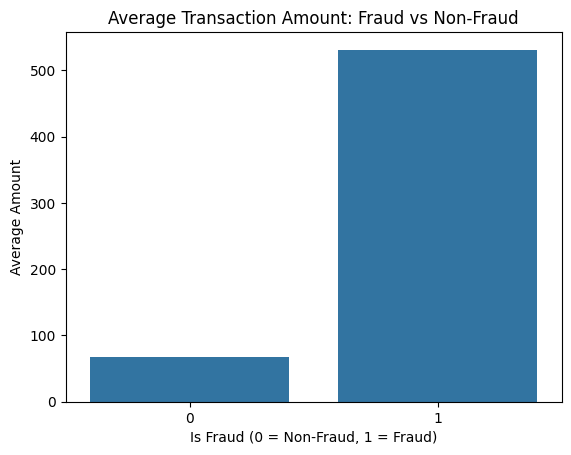

In [ ]:
# Example: Bar chart for average transaction amounts
avg_amt = cleansed_cc_data.groupBy("is_fraud").agg(avg(col("amount")).alias("avg_amt")).toPandas()

sns.barplot(data=avg_amt, x="is_fraud", y="avg_amt")
plt.title("Average Transaction Amount: Fraud vs Non-Fraud")
plt.xlabel("Is Fraud (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Average Amount")
plt.show()

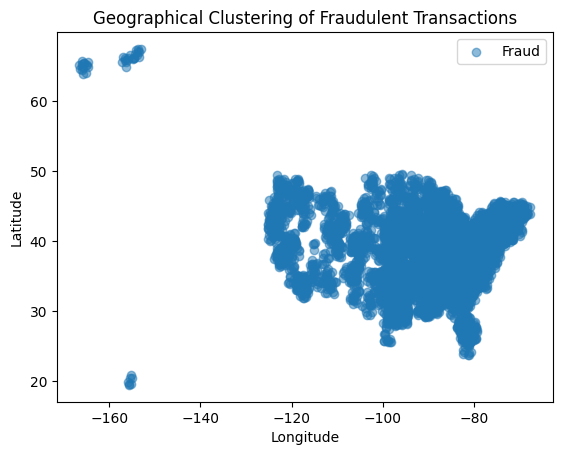

In [ ]:
# Example: Scatter plot of merchant locations
fraud_locations = cleansed_cc_data.filter(col("is_fraud") == "1").select("merch_lat", "merch_long").toPandas()

plt.scatter(fraud_locations['merch_long'], fraud_locations['merch_lat'], alpha=0.5, label="Fraud")
plt.title("Geographical Clustering of Fraudulent Transactions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

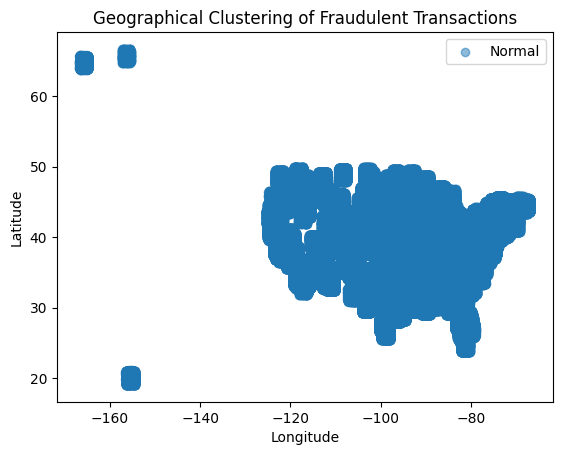

In [ ]:
# Example: Scatter plot of merchant locations
fraud_locations = cleansed_cc_data.filter(col("is_fraud") == "0").select("merch_lat", "merch_long").toPandas()

plt.scatter(fraud_locations['merch_long'], fraud_locations['merch_lat'], alpha=0.5, label="Normal")
plt.title("Geographical Clustering of Fraudulent Transactions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

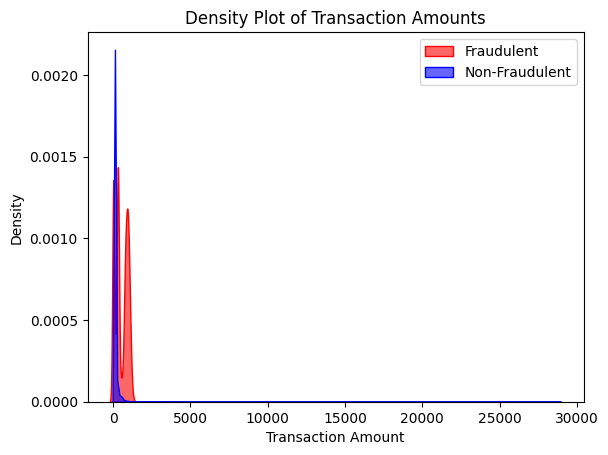

In [ ]:
# Step 1: Filter Data by Fraudulent and Non-Fraudulent Transactions
fraud_transactions_amount = fraud_transactions.select("amount").toPandas()
normal_transactions_amount = normal_transactions.select("amount").toPandas()

# Step 2: Extract Amounts for Plotting
fraud_transactions_amount = fraud_transactions_amount["amount"]
normal_transactions_amount = normal_transactions_amount["amount"]

sns.kdeplot(fraud_transactions_amount, color="red", label="Fraudulent", fill=True, alpha=0.6)
sns.kdeplot(normal_transactions_amount, color="blue", label="Non-Fraudulent", fill=True, alpha=0.6)
plt.title("Density Plot of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.legend()
plt.show()


In [22]:
# Step 2: Create Full Name Column
fraudulent_df = fraud_transactions.withColumn("full_name", concat_ws(" ", col("cc_owner_first_name"), col("cc_owner_last_name")))
non_fraudulent_df = normal_transactions.withColumn("full_name", concat_ws(" ", col("cc_owner_first_name"), col("cc_owner_last_name")))

# Step 3: Find Intersecting Names
common_names_df = fraudulent_df.select("full_name").intersect(non_fraudulent_df.select("full_name"))

# Step 4: Collect and Display Results
common_names = common_names_df.collect()
for row in common_names:
    print(row["full_name"])

Cheryl Melton
Kristin Williams
Kimberly Martin
Linda Davis
Brandon Bridges
Richard Carter
Jessica Potter
Andrea Perkins
Brittany Guerra
Kristina Stewart
Tracy Conway
Kenneth Sanchez
Mary Rodriguez
Lori Ramirez
John Davis
Samuel Farrell
Stacy Villegas
Cheryl Morgan
Christopher Carr
Christopher Rodgers
David Serrano
Stephanie Middleton
Joshua Bryant
Susan Hernandez
Lawrence Frost
Maria Rosales
Nathan Thomas
Amber Thornton
Alicia Mitchell
Steven Brooks
Terrance Mckinney
Diane Jackson
Jacqueline Washington
Teresa Blankenship
John Williams
Dylan Garcia
Belinda Jimenez
Stephanie Cummings
Michelle Anderson
Matthew Young
Larry Warner
Jesse Roberts
Derek Bentley
Jacqueline Caldwell
Paul Wade
Raymond Lloyd
Robert Jordan
Andrew Tucker
Xavier Beltran
Ashley Blanchard
Cody Dean
Christine Johnson
Matthew Lambert
Marissa Powell
Hannah Knight
Jacqueline Curry
Denise Barnett
Karen Warren
Daniel Melton
Kayla Obrien
Patrick Torres
Tanya Dickerson
Adam Mcdonald
Ronald Carson
Daniel Briggs
James Hunt
Tamar

In [28]:
fraudulent_names = fraudulent_df.select("full_name").distinct()
fraudulent_names = [row["full_name"] for row in fraudulent_names.collect()]
normal_names = non_fraudulent_df.select("full_name").distinct()
normal_names = [row["full_name"] for row in normal_names.collect()]
print(len(fraudulent_names), len(normal_names))

# # Step 4: Collect and Display Results
# exclusive_fraudulent_names = exclusive_fraudulent_names_df.distinct().collect()
# for row in exclusive_fraudulent_names:
#     print(row["full_name"])

754 901


In [31]:
fraud_people = [name for name in fraudulent_names if name not in normal_names]
print(fraud_people)

['Brian Ray', 'Bradley Adkins', 'Bryan Gill', 'Ashlee Long', 'Joe Allen', 'Chelsea Silva', 'Jeremy Chavez', 'Ryan Anderson', 'Larry Garcia', 'Daniel Hernandez', 'Mary Golden', 'Molly Marshall', 'Richard Moore', 'Christina Norris', 'Lisa Carpenter', 'Cody Blake', 'Sydney Morales', 'Misty Hart', 'Rachel Johnson', 'Colleen Morris', 'Mark Pennington', 'Jacob Snow', 'Christopher Wilson', 'Dakota Fowler', 'Michael Rivera', 'Jose Jones', 'David Santiago', 'Jennifer Johnson', 'Angelica Lopez', 'Calvin Molina', 'Dennis Jones', 'Danielle Schaefer', 'Kevin Hawkins', 'Austin Phillips', 'Brittany Mccarthy', 'Jacqueline Johnson', 'Tammy Mathews', 'Christopher Contreras', 'Benjamin Beck', 'John Ross', 'Kelly Lawrence', 'Savannah Clark', 'James Taylor', 'Robert Le', 'Phyllis Powell', 'Rachel Terrell', 'Julie Vasquez', 'Jeremy Nunez', 'Samuel Sellers', 'Robin Davis', 'Eric Dunn', 'Arthur Wells', 'Brandy Johnson', 'Karen Brewer', 'Jessica Rodgers', 'Emily Strong', 'Juan West', 'Diana Rodgers', 'Traci Br

In [38]:
fraud_transactions.filter(col("cc_owner_first_name") == "Ashlee").filter(col("cc_owner_last_name") == "Long").show(truncate=False)

+-----+-------+--------+-------------+------------------------------+---------------------------------+-------------------+------------------+------+-----------+-------------+-------------------+------------+-------------+---------------+------------+-------------+---------------+---------------------------------+---------------------------------+---------+----------+-------------+-----------+----------------+--------------------------------+
|id   |amount |is_fraud|category     |merchant                      |trans_time                       |cc_owner_first_name|cc_owner_last_name|gender|job        |date_of_birth|address_street     |address_city|address_state|address_zipcode|cc_owner_lat|cc_owner_long|city_population|merch_eff_time                   |merch_last_update_time           |merch_lat|merch_long|merch_zipcode|cc_bic     |cc_num          |trans_num                       |
+-----+-------+--------+-------------+------------------------------+---------------------------------+---

In [39]:
print(normal_names)

['Pamela Matthews', 'Mary Williams', 'Kimberly Bush', 'Gregory Graham', 'Melissa Krause', 'Rebecca Erickson', 'Jose Vasquez', 'Kathryn Smith', 'Donald Evans', 'Ana Howell', 'Angela West', 'Cheryl Melton', 'Mary Mcintyre', 'Jennifer Scott', 'Michael Lee', 'Gregory Wallace', 'Randall Burgess', 'Kristin Williams', 'Christopher Johnson', 'Jacob Weber', 'Kimberly Martin', 'Susan Garcia', 'Steven Johnson', 'Sabrina Johnson', 'Susan Shah', 'Robert Flores', 'Mckenzie Brooks', 'Natasha Mclaughlin', 'Tyler Small', 'Renee Walls', 'Kurt Peters', 'John Chandler', 'Peter Edwards', 'Katelyn Wise', 'Linda Davis', 'Michael Rowe', 'Margaret Ray', 'Angela Edwards', 'Cody Hooper', 'Richard Carter', 'Brandon Bridges', 'Jennifer Gonzalez', 'Brooke Fisher', 'Christine Best', 'Robert Long', 'Mark Brown', 'Kimberly Myers', 'Thomas Hale', 'Joseph Wagner', 'Collin Brown', 'Richard Marshall', 'Tyler Wright', 'Joshua Carpenter', 'Jessica Potter', 'Guy Thompson', 'Steven Sanders', 'Kristina Stewart', 'Monique Marti

In [42]:
normal_transactions.filter(col("cc_owner_first_name") == "Kimberly").filter(col("cc_owner_last_name") == "Bush").show(truncate=False)

+-----+------+--------+--------------+-----------------------------+---------------------------------+-------------------+------------------+------+--------------+-------------+----------------------------+------------+-------------+---------------+------------+-------------+---------------+---------------------------------+---------------------------------+---------+-----------+-------------+-----------+-------------------+--------------------------------+
|id   |amount|is_fraud|category      |merchant                     |trans_time                       |cc_owner_first_name|cc_owner_last_name|gender|job           |date_of_birth|address_street              |address_city|address_state|address_zipcode|cc_owner_lat|cc_owner_long|city_population|merch_eff_time                   |merch_last_update_time           |merch_lat|merch_long |merch_zipcode|cc_bic     |cc_num             |trans_num                       |
+-----+------+--------+--------------+-----------------------------+--------